In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import ndimage
import baseline_detection
from PIL import Image
import PIL
import warnings
import edge_superres
import criteria_definition
from matplotlib.pyplot import plot,text, cla, rcParams, text
import visualization
import os
from tools import drop_check
import shutil
import natsort
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def find_reds(pic):
    red_xs=np.where(pic[:,:,0]!=pic[:,:,1])[1]
    red_ys=np.where(pic[:,:,0]!=pic[:,:,1])[0]
    return(red_xs,red_ys)

def rotate_image(image, angle):
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

def load_files(ad):
    FileName=sorted(os.listdir(ad))
    FileNames=[]
    for i in range(len(FileName)):
        try:
            if FileName[i].split(".")[1]=="tif":
                FileNames=FileNames+[FileName[i]]
        except:
            pass
    FileNames=natsort.natsorted(FileNames)
    return(FileNames)

def slope_measurement(ad):
    pic_slope1=cv2.imread(ad+"\\slope\\1.bmp")
    pic_slope2=cv2.imread(ad+"\\slope\\2.bmp")
    red1_xs,red1_ys=find_reds(pic_slope1)
    red2_xs,red2_ys=find_reds(pic_slope2)
    dx=red2_xs-red1_xs
    dy=red2_ys-red1_ys
    gradian=np.arctan((dy)/(dx))
    angle=gradian*180/np.pi
    rotated1=rotate_image(pic_slope1, angle[0])
    return(angle[0],rotated1, red1_xs[0], red1_ys[0], red2_xs[0], red2_ys[0])

def make_folders(ad):
    NewFolder2=ad+"\\"+"SR_edge"
    try:
        os.makedirs(NewFolder2)
    except:
        shutil.rmtree(NewFolder2)
        os.makedirs(NewFolder2)
    NewFolder3=ad+"\\"+"SR_result"
    try:
        os.makedirs(NewFolder3)
    except:
        shutil.rmtree(NewFolder3)
        os.makedirs(NewFolder3)


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

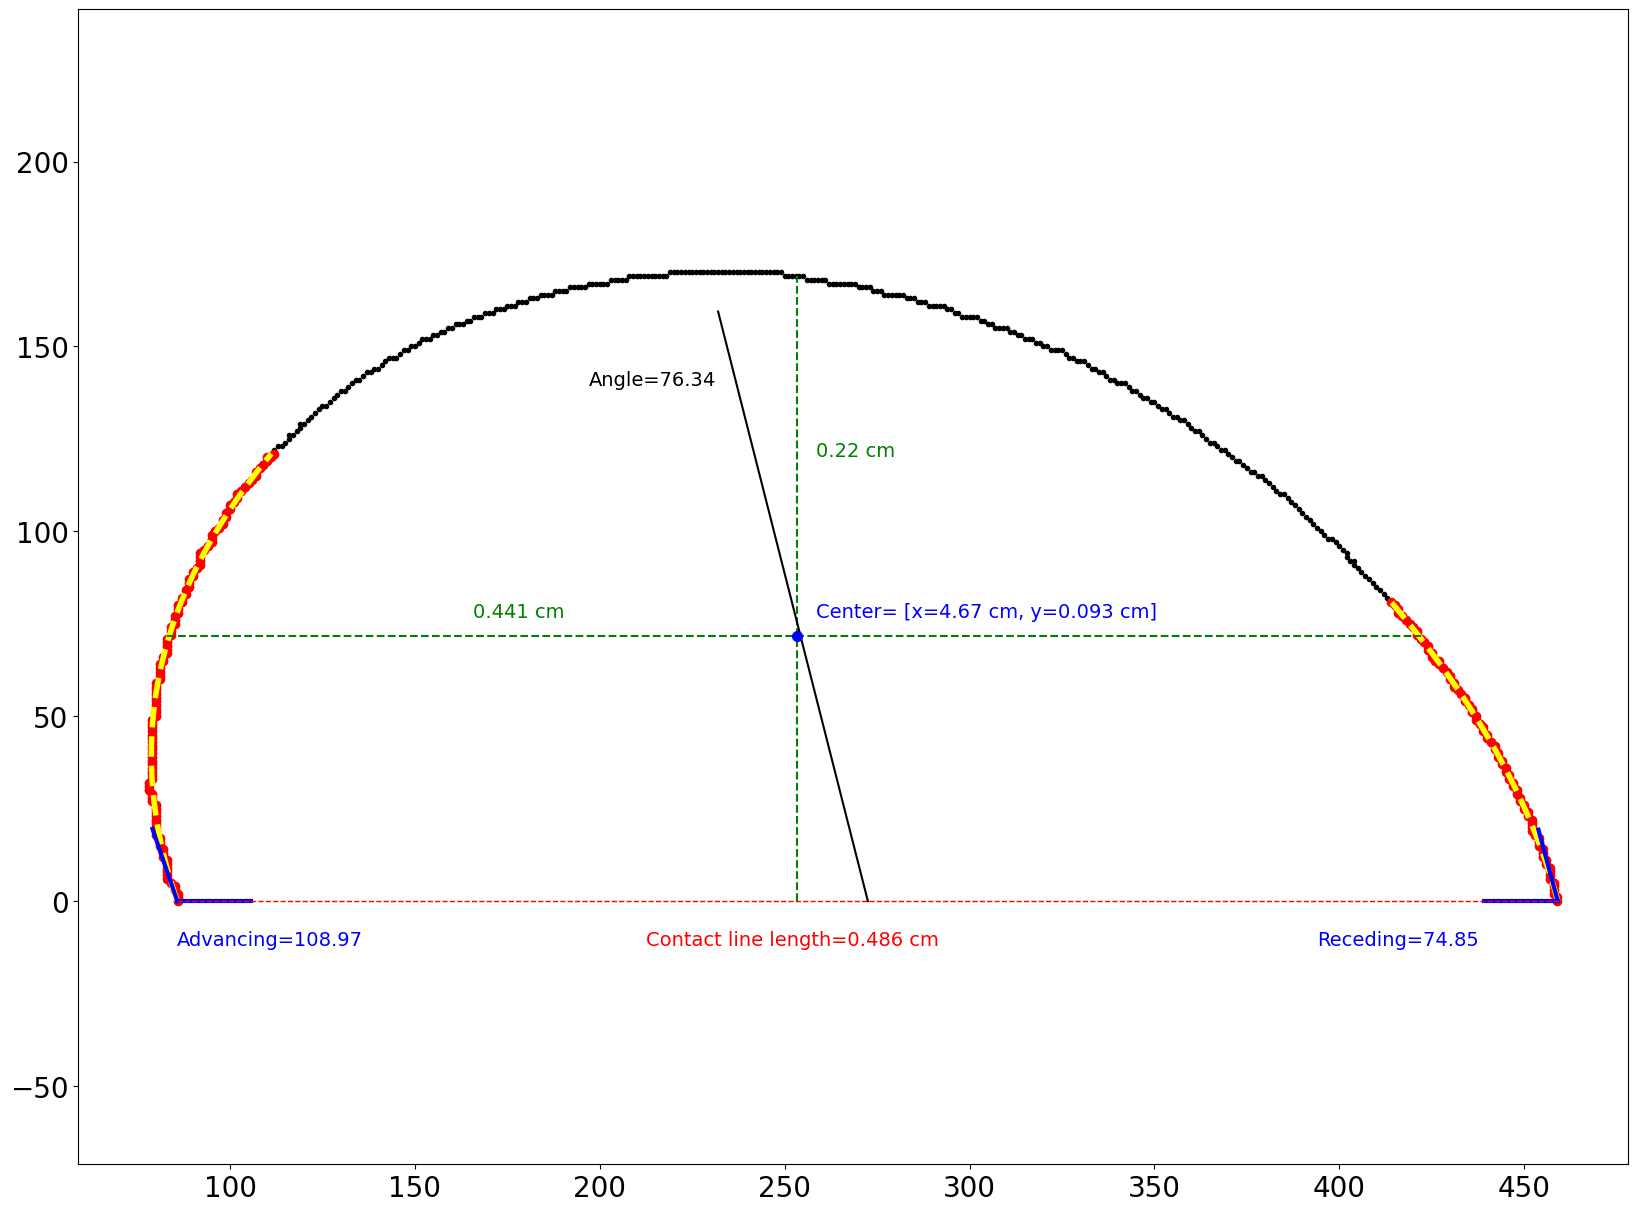

In [7]:
# set variables
ad=r"PFOTS sample with a defect"
fps=1000
cm_on_pixel_ratio= 0.0039062
error_handling_kernel_size=(5,5)
make_folders(ad)

# --------------------------------------------------------------------------

model=edge_superres.model_architecture("SuperRes_weights.h5")
angle, rotated1, red1_xs, red1_ys, red2_xs, red2_ys= slope_measurement(ad)
baseline=min(find_reds(rotated1)[1])-1
name_files=load_files(ad)
img_frame=cv2.imread(ad+'\\'+name_files[0])
img_frame_rotated=rotate_image(img_frame, angle)

adv_list, rec_list, contact_line_length_list, x_center_list, y_center_list, middle_angle_degree_list,processed_number_list=[],[],[],[],[],[],[]
rec_angle_point_list, adv_angle_point_list=[],[]

num_px_ratio=(0.0039062)/cm_on_pixel_ratio
for file_number in range(1, len(name_files)):
    print(file_number,end=", ")

    img_drop=cv2.imread(ad+'\\'+name_files[file_number])
    img_drop_rotated=rotate_image(img_drop, angle)

    #drop diff
    diff_img=cv2.absdiff(img_drop_rotated, img_frame_rotated)

    #drop cropping
    BaseL=baseline_detection.Baseline(baseline, middle_drop_height=25,drop_start_height=3*3, object_detection_threshold=40)
    drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
    just_drop =diff_img[dim[2]:baseline,dim[0]:dim[1],:]

    #super resolution    
    
    upscaled_image=edge_superres.upscale_image(model, cv2.cvtColor(just_drop.astype('uint8'), cv2.COLOR_BGR2RGB))

    #utilizing morphological transformation to remove noises
    kernel = np.ones(error_handling_kernel_size,np. uint8) 
    upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)

    #keeping just external pixels as droplet curvature
    i_list, j_list =edge_superres.edge_extraction( upscaled_image, thr=40)

    #extracting the desired number of pixels as input of the polynomial fitting 
    left_number_of_pixels=int(150*num_px_ratio)
    right_number_of_pixels=int(65*num_px_ratio)
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   

    left_polynomial_degree=3
    right_polynomial_degree=2
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)

    right_angle_degree,right_angle_point=criteria_definition.right_angle(i_poly_right_rotated, j_poly_right_rotated,1)
    left_angle_degree,left_angle_point=criteria_definition.left_angle(i_poly_left_rotated, j_poly_left_rotated,1)
    

    if left_angle_degree<=60 :
        left_number_of_pixels=int(60*num_px_ratio)
        left_polynomial_degree=2
    elif 60<left_angle_degree<=105:
        left_number_of_pixels=int(85*num_px_ratio)
        left_polynomial_degree=2
    elif 105<left_angle_degree<=135:
        left_number_of_pixels=int(125*num_px_ratio)  #175
        left_polynomial_degree=3
    elif 135<left_angle_degree:
        left_number_of_pixels=int(145*num_px_ratio) #215
        left_polynomial_degree=4

    if right_angle_degree<=60:
        right_number_of_pixels=int(60*num_px_ratio)
        right_polynomial_degree=2
    elif 60<right_angle_degree<=105:
        right_number_of_pixels=int(85*num_px_ratio)
        right_polynomial_degree=2
    elif 105<right_angle_degree<=135:
        right_number_of_pixels=int(125*num_px_ratio) #175
        right_polynomial_degree=3
    elif 135<right_angle_degree:
        right_number_of_pixels=int(145*num_px_ratio) #215
        right_polynomial_degree=4

    #9. extracting the desired number of pixels as input of the polynomial fitting 
    i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
    i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)

    #10. rotation for fitting, it can increase the accuracy to rotate 90 degrees and then fit the polynomial
    i_left_rotated,j_left_rotated=j_left,i_left       
    i_right_rotated,j_right_rotated=j_right,i_right   
    i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
    i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)
    j_poly_left=i_poly_left_rotated
    i_poly_left=j_poly_left_rotated
    j_poly_right=i_poly_right_rotated
    i_poly_right=j_poly_right_rotated
    x_cropped=dim[0]

    distance = (x_cropped) * 3
    address=ad+'\\'+'SR_edge'+'\\'+str(name_files[file_number])
    adv, rec,rec_angle_point, adv_angle_point, contact_line_length, x_center, y_center, middle_angle_degree=visualization.visualize(address, 
                                                                                                                                   distance+np.array(i_list),j_list,distance+np.array(i_left),j_left,distance+np.array(i_right),j_right,
                                                                                                                                   j_poly_left,distance+np.array(i_poly_left),j_poly_right,distance+np.array(i_poly_right),x_cropped,
                                                                                                                                   distance+np.array(i_poly_left_rotated), j_poly_left_rotated, distance+np.array(i_poly_right_rotated),
                                                                                                                                   j_poly_right_rotated, cm_on_pixel=cm_on_pixel_ratio, middle_line_switch=1)
    processed_number_list.append(int(name_files[file_number].split(".")[0].split("S0001")[-1]))
    adv_list.append(adv)
    rec_list.append(rec)
    adv_angle_point_list.append(adv_angle_point)
    rec_angle_point_list.append(rec_angle_point)
    contact_line_length_list.append(contact_line_length)
    x_center_list.append(x_center)
    y_center_list.append(y_center)
    middle_angle_degree_list.append(middle_angle_degree)

vel=[]
for i in range(len(x_center_list)-1):
    vel=vel+[x_center_list[i+1]-x_center_list[i]]

vel=np.array(vel)*fps
df=pd.DataFrame([processed_number_list, np.arange(0, 1/fps*len(vel), 1/fps), x_center_list, adv_list,rec_list,contact_line_length_list, y_center_list, middle_angle_degree_list, vel]).T
df=df[:-1]

df.columns=['file number', "time (s)", 'x_center (cm)', 'adv (degree)', 'rec (degree)', 'contact_line_length (cm)', 'y_center (cm)', 'middle_angle_degree (degree)', 'velocity (cm/s)']

filter_size=9


df["adv (degree)"]=savgol_filter(df["adv (degree)"], filter_size, 2)

df["rec (degree)"]=savgol_filter(df["rec (degree)"], filter_size, 2)

df["contact_line_length (cm)"]=savgol_filter(df["contact_line_length (cm)"], filter_size, 2)

df["y_center (cm)"]=savgol_filter(df["y_center (cm)"], filter_size, 2)

df["middle_angle_degree (degree)"]=savgol_filter(df["middle_angle_degree (degree)"], filter_size, 2)

df["velocity (cm/s)"]=savgol_filter(df["velocity (cm/s)"], filter_size, 2)


df.to_excel(ad+'\\'+'SR_result'+'\\'+'result.xlsx')

 it is analyzing folder: 1 --------------------------------------------------
 it is analyzing folder: 2 --------------------------------------------------
 it is analyzing folder: 3 --------------------------------------------------
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 

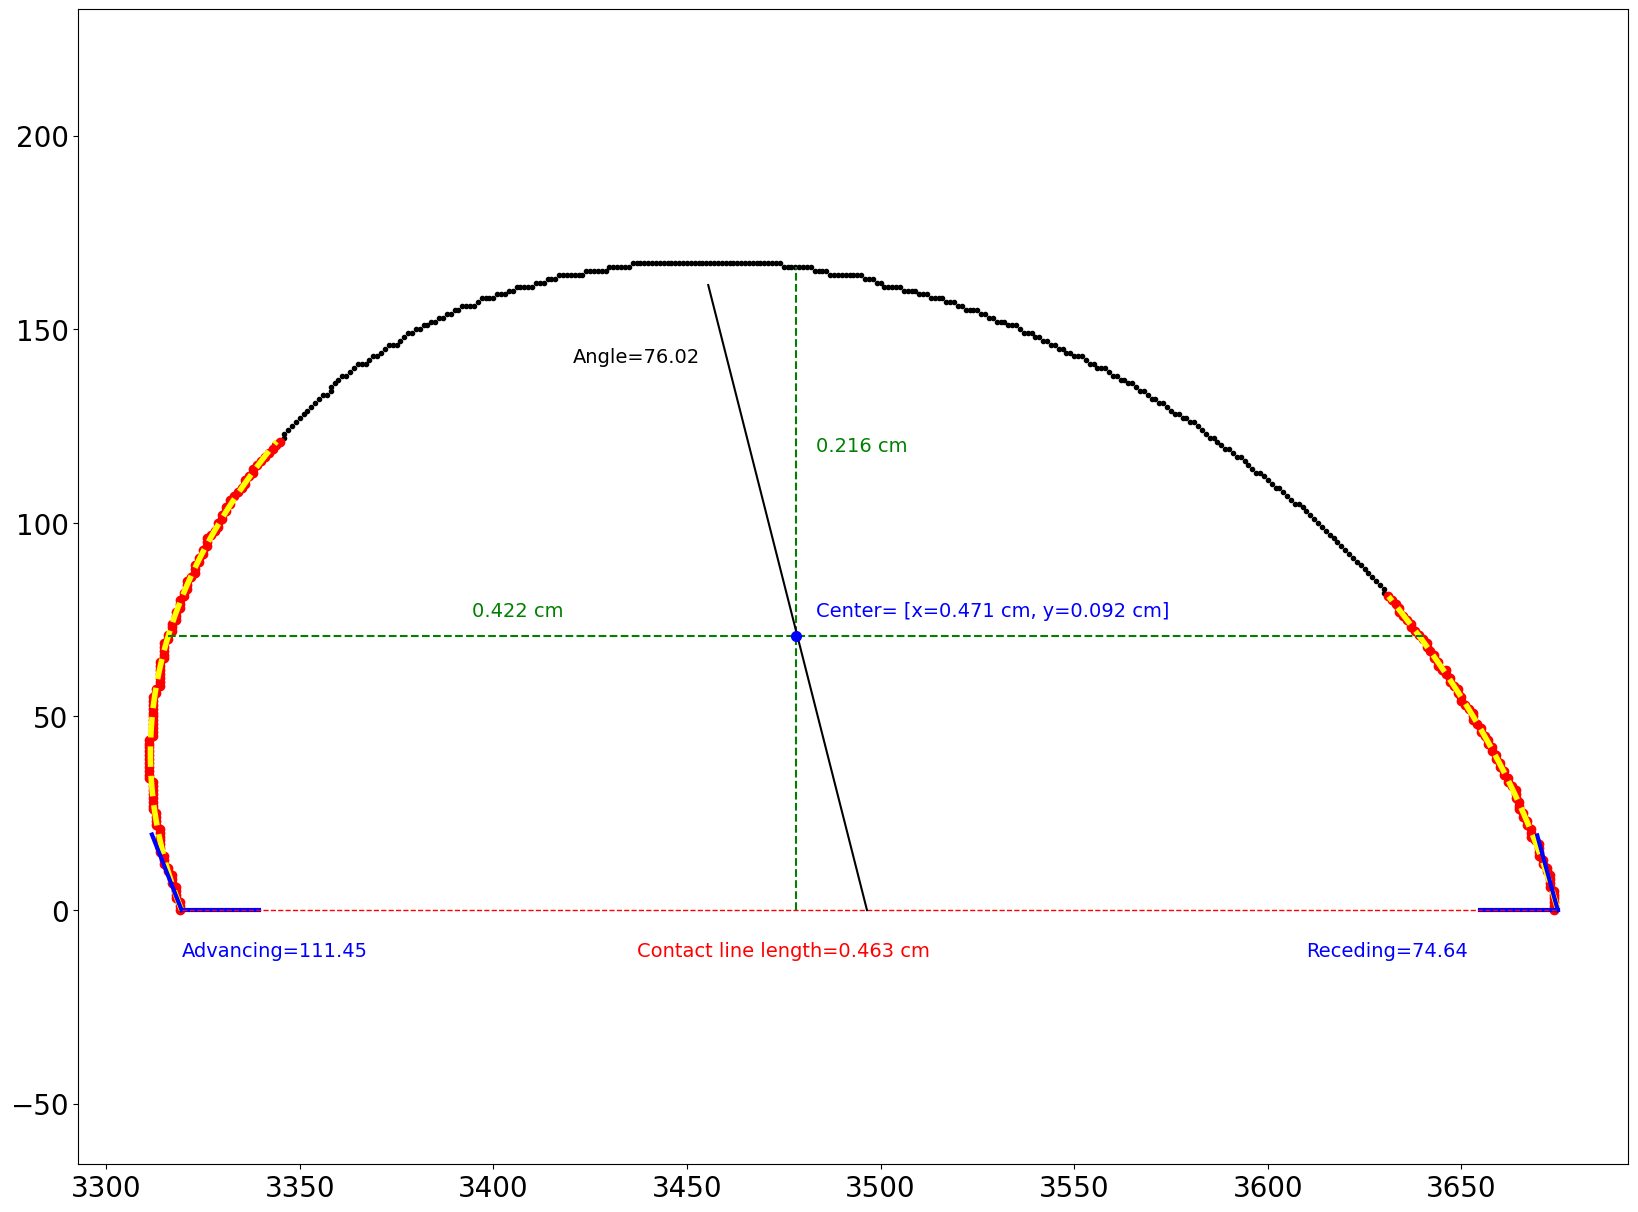

In [5]:
#Batch analysis cell
#Batch analysis involves processing multiple files in one go, and this cell helps by specifying the path to the main folder containing all the subfolders for analysis.


# set variables
folder_path = r"various_experiments" #Provide the path to the main folder containing multiple video subfolders.
fps=1000
cm_on_pixel_ratio= 0.0039062
error_handling_kernel_size=(5,5)

# --------------------------------------------------------------------------
folders = [f.name for f in os.scandir(folder_path) if f.is_dir()]
model=edge_superres.model_architecture("SuperRes_weights.h5")

for folder in folders:
    print("\r The folder under analysis:", folder,"--------------------------------------------------")
    ad=folder_path+"\\"+folder
    make_folders(ad)
    angle, rotated1, red1_xs, red1_ys, red2_xs, red2_ys= slope_measurement(ad)
    baseline=min(find_reds(rotated1)[1])-1
    name_files=load_files(ad)
    img_frame=cv2.imread(ad+'\\'+name_files[0])
    img_frame_rotated=rotate_image(img_frame, angle)
    
    adv_list, rec_list, contact_line_length_list, x_center_list, y_center_list, middle_angle_degree_list,processed_number_list=[],[],[],[],[],[],[]
    rec_angle_point_list, adv_angle_point_list=[],[]
    
    num_px_ratio=(0.0039062)/cm_on_pixel_ratio
    for file_number in range(1, len(name_files)):
        print(file_number,end=", ")
    
        img_drop=cv2.imread(ad+'\\'+name_files[file_number])
        img_drop_rotated=rotate_image(img_drop, angle)
    
        #drop diff
        diff_img=cv2.absdiff(img_drop_rotated, img_frame_rotated)
    
        #drop cropping
        BaseL=baseline_detection.Baseline(baseline, middle_drop_height=25,drop_start_height=3*3, object_detection_threshold=40)
        drop_reflection,*dim=BaseL.drop_cropping(diff_img, x_left_margin=30, x_right_margin=60,y_up_margin=10)
        just_drop =diff_img[dim[2]:baseline,dim[0]:dim[1],:]
    
        #super resolution    
        
        upscaled_image=edge_superres.upscale_image(model, cv2.cvtColor(just_drop.astype('uint8'), cv2.COLOR_BGR2RGB))
    
        #utilizing morphological transformation to remove noises
        kernel = np.ones(error_handling_kernel_size,np. uint8) 
        upscaled_image=cv2.morphologyEx(np.array(upscaled_image), cv2.MORPH_CLOSE, kernel)
    
        #keeping just external pixels as droplet curvature
        i_list, j_list =edge_superres.edge_extraction( upscaled_image, thr=40)
    
        #extracting the desired number of pixels as input of the polynomial fitting 
        left_number_of_pixels=int(150*num_px_ratio)
        right_number_of_pixels=int(65*num_px_ratio)
        i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
        i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)
    
        #rotation for fitting, it can increase the accuracy to rotate 90 degrees then fit the polynomial
        i_left_rotated,j_left_rotated=j_left,i_left       
        i_right_rotated,j_right_rotated=j_right,i_right   
    
        left_polynomial_degree=3
        right_polynomial_degree=2
        i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
        i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)
    
        right_angle_degree,right_angle_point=criteria_definition.right_angle(i_poly_right_rotated, j_poly_right_rotated,1)
        left_angle_degree,left_angle_point=criteria_definition.left_angle(i_poly_left_rotated, j_poly_left_rotated,1)
        
    
        if left_angle_degree<=60 :
            left_number_of_pixels=int(60*num_px_ratio)
            left_polynomial_degree=2
        elif 60<left_angle_degree<=105:
            left_number_of_pixels=int(85*num_px_ratio)
            left_polynomial_degree=2
        elif 105<left_angle_degree<=135:
            left_number_of_pixels=int(125*num_px_ratio)  #175
            left_polynomial_degree=3
        elif 135<left_angle_degree:
            left_number_of_pixels=int(145*num_px_ratio) #215
            left_polynomial_degree=4
    
        if right_angle_degree<=60:
            right_number_of_pixels=int(60*num_px_ratio)
            right_polynomial_degree=2
        elif 60<right_angle_degree<=105:
            right_number_of_pixels=int(85*num_px_ratio)
            right_polynomial_degree=2
        elif 105<right_angle_degree<=135:
            right_number_of_pixels=int(125*num_px_ratio) #175
            right_polynomial_degree=3
        elif 135<right_angle_degree:
            right_number_of_pixels=int(145*num_px_ratio) #215
            right_polynomial_degree=4
    
        #9. extracting the desired number of pixels as input of the polynomial fitting 
        i_left, j_left=criteria_definition.advancing_pixel_selection(i_list,j_list, left_number_of_pixels=left_number_of_pixels)
        i_right, j_right=criteria_definition.receding_pixel_selection(i_list,j_list, right_number_of_pixels=right_number_of_pixels)
    
        #10. rotation for fitting, it can increase the accuracy to rotate 90 degrees and then fit the polynomial
        i_left_rotated,j_left_rotated=j_left,i_left       
        i_right_rotated,j_right_rotated=j_right,i_right   
        i_poly_left_rotated, j_poly_left_rotated=criteria_definition.poly_fitting(i_left_rotated,j_left_rotated,polynomial_degree=left_polynomial_degree,line_space=left_number_of_pixels)
        i_poly_right_rotated, j_poly_right_rotated=criteria_definition.poly_fitting(i_right_rotated,j_right_rotated,polynomial_degree=right_polynomial_degree,line_space=right_number_of_pixels)
        j_poly_left=i_poly_left_rotated
        i_poly_left=j_poly_left_rotated
        j_poly_right=i_poly_right_rotated
        i_poly_right=j_poly_right_rotated
        x_cropped=dim[0]
    
        distance = (x_cropped) * 3
        address=ad+'\\'+'SR_edge'+'\\'+str(name_files[file_number])
        adv, rec,rec_angle_point, adv_angle_point, contact_line_length, x_center, y_center, middle_angle_degree=visualization.visualize(address, 
                                                                                                                                       distance+np.array(i_list),j_list,distance+np.array(i_left),j_left,distance+np.array(i_right),j_right,
                                                                                                                                       j_poly_left,distance+np.array(i_poly_left),j_poly_right,distance+np.array(i_poly_right),x_cropped,
                                                                                                                                       distance+np.array(i_poly_left_rotated), j_poly_left_rotated, distance+np.array(i_poly_right_rotated),
                                                                                                                                       j_poly_right_rotated, cm_on_pixel=cm_on_pixel_ratio, middle_line_switch=1)
        processed_number_list.append(int(name_files[file_number].split(".")[0].split("S0001")[-1]))
        adv_list.append(adv)
        rec_list.append(rec)
        adv_angle_point_list.append(adv_angle_point)
        rec_angle_point_list.append(rec_angle_point)
        contact_line_length_list.append(contact_line_length)
        x_center_list.append(x_center)
        y_center_list.append(y_center)
        middle_angle_degree_list.append(middle_angle_degree)
    
    vel=[]
    for i in range(len(x_center_list)-1):
        vel=vel+[x_center_list[i+1]-x_center_list[i]]
    
    vel=np.array(vel)*fps
    df=pd.DataFrame([processed_number_list, np.arange(0, 1/fps*len(vel), 1/fps), x_center_list, adv_list,rec_list,contact_line_length_list, y_center_list, middle_angle_degree_list, vel]).T
    df=df[:-1]
    
    df.columns=['file number', "time (s)", 'x_center (cm)', 'adv (degree)', 'rec (degree)', 'contact_line_length (cm)', 'y_center (cm)', 'middle_angle_degree (degree)', 'velocity (cm/s)']
    
    filter_size=9
    
    
    df["adv (degree)"]=savgol_filter(df["adv (degree)"], filter_size, 2)
    
    df["rec (degree)"]=savgol_filter(df["rec (degree)"], filter_size, 2)
    
    df["contact_line_length (cm)"]=savgol_filter(df["contact_line_length (cm)"], filter_size, 2)
    
    df["y_center (cm)"]=savgol_filter(df["y_center (cm)"], filter_size, 2)
    
    df["middle_angle_degree (degree)"]=savgol_filter(df["middle_angle_degree (degree)"], filter_size, 2)
    
    df["velocity (cm/s)"]=savgol_filter(df["velocity (cm/s)"], filter_size, 2)
    
    
    df.to_excel(ad+'\\'+'SR_result'+'\\'+'result.xlsx')


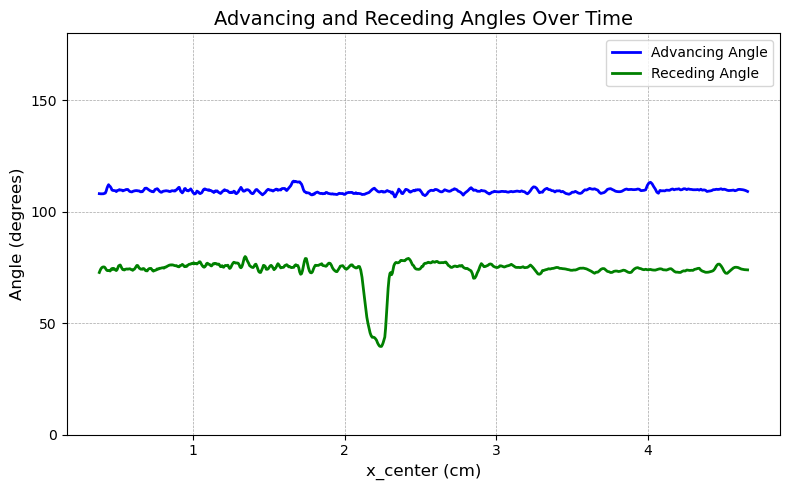

In [18]:
plt.figure(figsize=(8, 5))  # Adjust the size of the figure
plt.plot(df["x_center (cm)"], df["adv (degree)"], label="Advancing Angle", color="blue", linestyle="-", linewidth=2)
plt.plot(df["x_center (cm)"], df["rec (degree)"], label="Receding Angle", color="green", linestyle="-", linewidth=2)

# Adding titles and labels
plt.title("Advancing and Receding Angles Over Time", fontsize=14)
plt.xlabel("x_center (cm)", fontsize=12)
plt.ylabel("Angle (degrees)", fontsize=12)

# Customizing the grid
plt.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)

plt.ylim(0, 180)

# Adding a legend
plt.legend(fontsize=10, loc="best")

# Improving axis ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Display the plot
plt.tight_layout()  # Ensures everything fits well
plt.show()
